### Importing relevent libraries

In [28]:
import os
import PIL
import PIL.Image
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np
from livelossplot import PlotLossesKerasTF
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.8.3


Check if GPU is availabl.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading data and creating datasets

In [3]:
os.chdir("..")

In [4]:
# Creating paths with data
DATA_DIR = Path('data')
DATA_DIR_TRAIN = DATA_DIR / 'train'
DATA_DIR_TEST = DATA_DIR / 'test_kaggle'

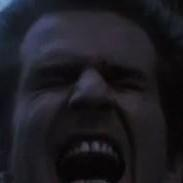

In [5]:
# Checking traim path
anger = list(DATA_DIR_TRAIN.glob('anger/*'))
PIL.Image.open(str(anger[0]))

In [6]:
# Folders with images are structured by classes, so we can use image_dataset_from_directory.
BATCH_SIZE = 64
IMG_HEIGHT = 200
IMG_WIDTH = 200

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

valid_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

Found 50047 files belonging to 9 classes.
Using 40038 files for training.
Found 50047 files belonging to 9 classes.
Using 10009 files for validation.


In [7]:
# Checking classes
class_names = train_ds.class_names
print(class_names)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']


In [49]:
emotion_mapping = {v: k for v, k in enumerate(class_names)}
emotion_mapping

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

### Creating custom model.

In [11]:
augmentation_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                          tf.keras.layers.RandomRotation(0.1),
                                          tf.keras.layers.RandomContrast(0.1)])
normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1) # data preprocessing (scaling and centering)    

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = augmentation_layer(inputs)
x = normalization_layer(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.SpatialDropout2D(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model_norm_aug = tf.keras.Model(inputs, outputs)

In [12]:
model_norm_aug.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 average_pooling2d_1 (Averag  (None, 100, 100, 32)     0         
 ePooling2D)                                                     
                                                           

In [18]:
LR = 1e-4
EPOCHS = 15

model_norm_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])

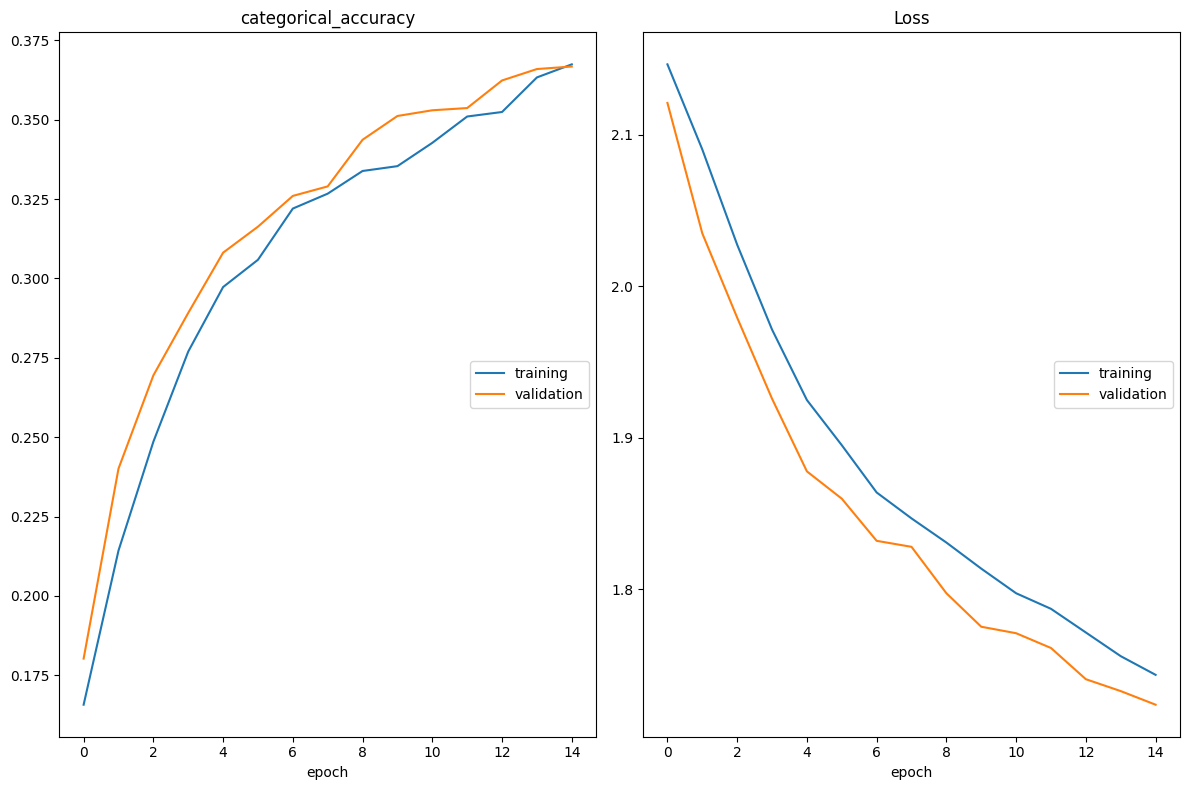

categorical_accuracy
	training         	 (min:    0.166, max:    0.367, cur:    0.367)
	validation       	 (min:    0.180, max:    0.367, cur:    0.367)
Loss
	training         	 (min:    1.744, max:    2.147, cur:    1.744)
	validation       	 (min:    1.724, max:    2.121, cur:    1.724)
626/626 [==============================] - 87s 138ms/step - loss: 1.7435 - categorical_accuracy: 0.3675 - val_loss: 1.7238 - val_categorical_accuracy: 0.3668


In [19]:
history_norm_aug = model_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b>Categorical accuracy is much better, than on previous models. But model overfits, adding dropout layer.</b>

In [13]:
augmentation_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                          tf.keras.layers.RandomRotation(0.1),
                                          tf.keras.layers.RandomContrast(0.1)])
normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)    

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = augmentation_layer(inputs)
x = normalization_layer(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.SpatialDropout2D(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model_norm_aug_2 = tf.keras.Model(inputs, outputs)

In [14]:
model_norm_aug_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 average_pooling2d_3 (Averag  (None, 100, 100, 32)     0         
 ePooling2D)                                                     
                                                           

In [15]:
LR = 1e-4
EPOCHS = 15

model_norm_aug_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])

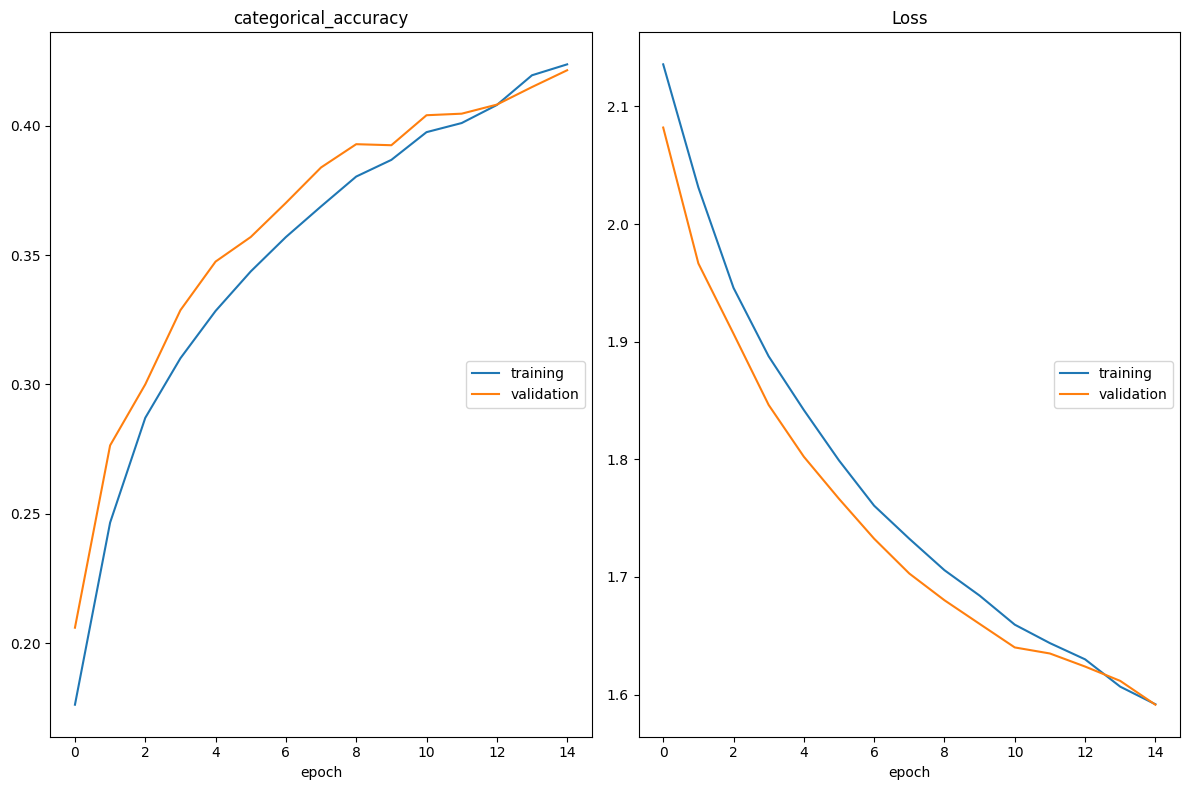

categorical_accuracy
	training         	 (min:    0.176, max:    0.424, cur:    0.424)
	validation       	 (min:    0.206, max:    0.421, cur:    0.421)
Loss
	training         	 (min:    1.592, max:    2.136, cur:    1.592)
	validation       	 (min:    1.591, max:    2.082, cur:    1.591)
626/626 [==============================] - 101s 160ms/step - loss: 1.5917 - categorical_accuracy: 0.4237 - val_loss: 1.5913 - val_categorical_accuracy: 0.4214


In [17]:
history_norm_aug = model_norm_aug_2.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b>Categorical accuracy is very good, without overfitting. Saving as best model.</b>

In [23]:
model_norm_aug_2.save('models/model_norm_aug_custom_2/model_norm_aug_custom_2_15', save_format='h5')

In [10]:
model_norm_aug_2 = tf.keras.models.load_model('models/model_norm_aug_custom_2/model_norm_aug_custom_2_15')